# Creating 3D Travel Time Model and Function

In [1]:
# Import libraries
import pyekfmm as fmm
import numpy as np
import pandas as pd
import json
import pyproj
import matplotlib.pyplot as plt

In [2]:
# Read the .npy files for vp_s and vs_s
ruta_vp = "/Users/cecilia/PYEIFMM/vp_s.npy"
ruta_vs = "/Users/cecilia/PYEIFMM/vs_s.npy"

In [3]:
# Load the array vp and vs from the .npy file
velp = np.load(ruta_vp)
vels = np.load(ruta_vs)

In [4]:
# Visualize the arrays shape for Vp and Vs
velp.shape
vels.shape

(552, 560, 87)

In [5]:
# Slice the 3D-array 'vels' to select a submatrix
vels = vels[0:552, 0:560, 0:87]

In [6]:
vels.shape

(552, 560, 87)

In [7]:
# File path of .json file
json_file = '/Users/cecilia/PYEIFMM/proyections.json'

In [8]:
# Open the .json file and load the content into a param_da dictionary
with open(json_file, 'r') as file:
    param_da = json.load(file)

In [9]:
param_da

{'min_long': -119.0,
 'max_long': -116.0,
 'min_lat': 34.5,
 'max_lat': 37.0,
 'crs_geo': 'EPSG:4326',
 'crs_proy': 'EPSG:26711',
 'min_x': 316459.9297286207,
 'min_y': 3817400.650678637,
 'min_z': -3000.0,
 'nrx': 552,
 'nry': 560,
 'nrz': 87}

## We will need a code routine for center and make an square of 130.5 x 130.5 kilometers

#### Project the velocity model to the initial coordinate used by CNQ

In [10]:
# The lower left coordinate used by CNQ is (-118.2, 35.2)
newx = [-118.2]
newy = [35.2]

#### Define station (CI.CLC) coodinates

In [11]:
stax = [-117.59751]    #Longitude of CI.CLC
stay = [35.81574]    # latitude of CI.CLC


In [12]:
# Define the input coordinates system (latitude and longitude)
input_crs = pyproj.CRS("EPSG:4326")  # EPSG:4326 represents WGS 84 (latitude and longitude)

# Define the output coordinates system (latitude and longitude)
output_crs = pyproj.CRS("EPSG:26711")  # EPSG:26711 represents UTM Zone 11 in the North hemisphere, NAD27)

# Create a coordinates transformer
transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)

# Transform the latitude and longitude columns
xpro, ypro = transformer.transform(newx,newy)

# Transform the latitude and longitude station (CI.CLC) coodinates
stax_pro, stay_pro = transformer.transform(stax, stay)

In [13]:
# Print transformed coordinates
print(xpro,ypro)
print(stax_pro,stay_pro)

[390842.0649037537] [3895685.266554819]
[446102.0001740841] [3963479.2549531744]


In [14]:
# Adjust station coordinates to the new origin coordinates (defined by CNQ coordinates)
CLCx = stax_pro[0] - xpro[0]
CLCy = stay_pro[0] - ypro[0]
print("The station CLC coordinates in the projected system are: ({}, {})".format(CLCx, CLCy))

The station CLC coordinates in the projected system are: (55259.9352703304, 67793.98839835543)


In [15]:
# Latitude and longitude delta index (longitude and latitude intervals)
xdel = int((xpro[0]-param_da['min_x'])/500)
ydel = int((ypro[0]-param_da['min_y'])/500)

# Station coordinates delta index
stax_del = int((stax_pro[0]-param_da['min_x'])/500)
stay_del = int((stay_pro[0]-param_da['min_y'])/500)

In [16]:
print(xdel,ydel) # Delta index for new origin defined by CNQ
print(stax_del,stay_del) # Delta index for station longitude and latitude

148 156
259 292


In [17]:
# Extract elements of the P-velocities matrix (261 elements starting at xdel and ydel)
velp = velp[xdel:(xdel+261), ydel:(ydel+261), :]

# Extract elements of the S-velocities matrix (261 elements starting at xdel and ydel)
vels = vels[xdel:(xdel+261), ydel:(ydel+261), :]

In [18]:
# Get the last value along axis 2 (index 87-1)
last_value_p = velp[:, :, -1]

# Create a new ndarray with shape (261, 261, 261) where the last value is repeated
new_shape_p = (261, 261, 261)
new_velp = np.repeat(last_value_p[:, :, np.newaxis], new_shape_p[2], axis=2)

# Now, 'new_data' contains the desired structure with the last value repeated
print(new_velp.shape) # Should print (261, 261, 261)

(261, 261, 261)


In [19]:
# Get the last value along axis 2 (index 87-1)
last_value_s = vels[:, :, -1]

# Create a new ndarray with shape (261, 261, 261) where the last value is repeated
new_shape_s = (261, 261, 261)
new_vels = np.repeat(last_value_s[:, :, np.newaxis], new_shape_s[2], axis=2)

# Now, 'new_data' contains the desired structure with the last value repeated
print(new_vels.shape) # Should print (261, 261, 261)

(261, 261, 261)


In [20]:
# Reshape the 'new_velp' matrix to a one-dimensional array with column-major order
vpp = new_velp.reshape([261*261*261,1], order='F')

In [21]:
vpp

array([[7.9608607],
       [7.962157 ],
       [7.9640994],
       ...,
       [8.106132 ],
       [8.107464 ],
       [8.100649 ]], dtype=float32)

In [22]:
# Reshape the 'new_vels' matrix to a one-dimensional array with column-major order
vss = new_vels.reshape([261*261*261,1],order='F')

In [23]:
vss

array([[4.380311 ],
       [4.3829603],
       [4.384828 ],
       ...,
       [4.349711 ],
       [4.347332 ],
       [4.345364 ]], dtype=float32)

# Calcuating 3D Travel Times based on Eikonal's Function

## This code was modified from Yangkang Chen, 2022, The University of Texas at Austin.

In [24]:
# Caulculate P and S wave times based on Eikonal's function
tp = fmm.eikonal(vpp, xyz=np.array([61,60,8]),ax=[0,0.5,261],ay=[0,0.5,261],az=[-3,0.5,261],order=2);
ts = fmm.eikonal(vss, xyz=np.array([61,60,8]),ax=[0,0.5,261],ay=[0,0.5,261],az=[-3,0.5,261],order=2);

In [25]:
# Reshape the 'tp' and 'ts' matrix to a one-dimensional array with column-major order
ttp = tp.reshape(261,261,261,order='F')
tts = ts.reshape(261,261,261,order='F')

In [26]:
# Calculate the difference between P ans S times
tsp = tts - ttp

In [27]:
# Extract the first layer (index 0) along the third dimension from the 'tsp' matrix
tn = tsp[:,:,0]
# This will be used for the contour plot

In [28]:
# Reshape the 2D array 'tn' to have dimensions (261, 261)
tn = tn.reshape(261, 261)

#### Contour plot

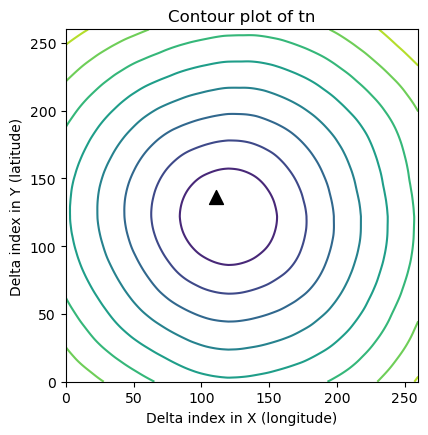

In [29]:
# Plot contour times plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121,aspect=1.0)
plt.contour(tn, levels=np.linspace(tn.min(), tn.max(), 10))
plt.scatter(111,136,s=100,marker='^',color='black', label='CI.CLC')
plt.xlabel('Delta index in X (longitude)')
plt.ylabel('Delta index in Y (latitude)')
plt.title('Contour plot of tn')

# Show the plot
plt.show()

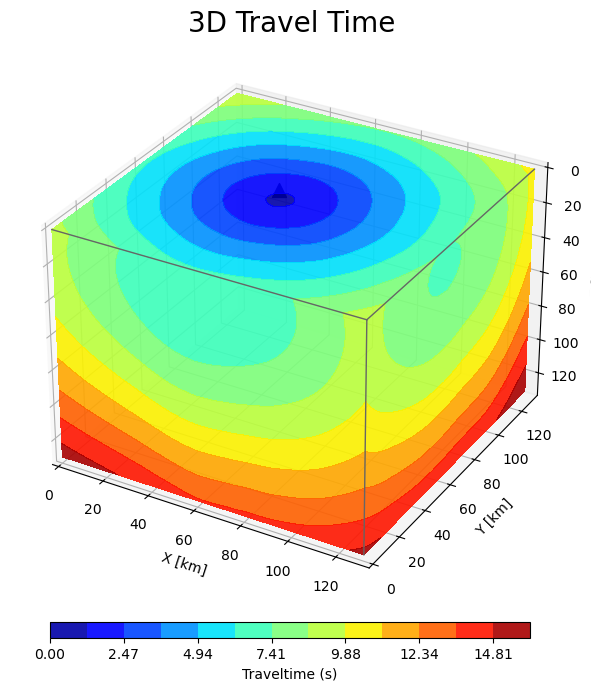

In [30]:
#Modified from Yangkang Chen, 2022. The University of Texas at Austin.

# Define matrix dimensions
Nx, Ny, Nz = 261, 261, 261
X, Y, Z = np.meshgrid(np.arange(Nx)*.5, np.arange(Ny)*.5, np.arange(Nz)*.5)

# Specify the 3D data
data = tsp
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'alpha': 0.9,
    'levels': np.linspace(data.min(), data.max(), 14),
}

# Create a figure with 3D axes
fig = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
plt.jet()
ax = fig.add_subplot(121, projection='3d')

# Plot contour surfaces
_ = ax.contourf(X[:, :, -1], Y[:, :, -1], data[:, :, 0], zdir='z', offset=0, **kw)
_ = ax.contourf(X[0, :, :], data[0, :, :], Z[0, :, :], zdir='y', offset=0, **kw)
C = ax.contourf(data[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)

# Set limits of the plot from coordinates limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

#Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(xlabel='X [km]', ylabel='Y [km]', zlabel='Z [km]')

# Set zoom and angle view
# ax.view_init(40, -30, 0)
# ax.set_box_aspect(None, zoom=0.9)

plt.gca().scatter(CLCx/1000, CLCy/1000, 0, s=100, marker='^', color='black', label='CI.CLC') #(x, y, z)
plt.gca().set_xlim(0,131);
plt.gca().set_ylim(0,131);
plt.gca().set_zlim(0,131)
plt.title('3D Travel Time', color='k', fontsize=20)
plt.gca().invert_zaxis()

# Position for the colorbar
cb = plt.colorbar(C, cax = fig.add_axes([0.15,0.1,0.3,0.02]), format= "%4.2f", orientation='horizontal',label='Traveltime (s)')

# Save image plot
plt.savefig('test_pyekfmm_fig2.png',format='png',dpi=300,bbox_inches='tight', pad_inches=0)
plt.savefig('test_pyekfmm_fig2.pdf',format='pdf',dpi=300,bbox_inches='tight', pad_inches=0)

# Show Figure
plt.show()

In [31]:
tsp.shape

(261, 261, 261)

# Define Travel Time Function of 3D Coordinates

In [32]:
def get_travel_time(X,Y,Z):
    # Redondea las coordenadas X, Y y Z a las divisiones del grid de 500 metros
    X_rounded = round(X / 500) * 500
    Y_rounded = round(Y / 500) * 500
    Z_rounded = round(Z / 500) * 500
    # Encuentra los índices correspondientes en el arreglo tsp
    x_index = int(X_rounded / 500)
    y_index = int(Y_rounded / 500)
    z_index = int(Z_rounded / 500)
    # Obtiene el valor del tiempo en el arreglo tsp usando los índices
    print(x_index, y_index, z_index)
    time = tsp[x_index, y_index, z_index]

    return time

In [33]:
t = get_travel_time(CLCx, CLCy, 0)

111 136 0


In [34]:
t

1.4839413

#### Que en el primer caso calcule en automatico el cero de referencia del algoritmo de TT. 
#### Restringir a 80% de probabilidad de P y S